# Analyse New Signal Cuts

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array

Populating the interactive namespace from numpy and matplotlib


## Import the Signal Hits

In [10]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
signal_files  = ["oa_xx_xxx_09100000-0000_opgjz6dop7ho_user-TrkTree_000_signal-label.root",
              "oa_xx_xxx_09200000-0000_bxszqgjrri2n_user-TrkTree_000_signal-label.root",
              "oa_xx_xxx_09400000-0000_7i52rtj3sz5v_user-TrkTree_000_signal-label.root",
              "oa_xx_xxx_09600000-0000_xjij4zcypjul_user-TrkTree_000_signal-label.root",
              "oa_xx_xxx_09800000-0000_b72ef5hzppor_user-TrkTree_000_signal-label.root",
              "oa_xx_xxx_09900000-0000_orbwudhvihxn_user-TrkTree_000_signal-label.root"]
signal_files = ["oa_xx_xxx_09000000-0000_xxp5rensumkk_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09100000-0000_rehgezljgw64_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09200000-0000_mph7uojlccp3_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09300000-0000_wnttm2so5oko_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09400000-0000_bgembg7smnkn_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09500000-0000_4une3z4gro25_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09600000-0000_ttnnaklevifh_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09700000-0000_nsq7pyp3mpou_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09800000-0000_vufc7dmob2jd_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09900000-0000_3tyfcytheyr6_user-TrkTree_000_700signal-label.root"]

back_files = ["batch_4_TrkTree_2500.root",
              "batch_3_TrkTree_2536.root",
              "batch_2_TrkTree_2500.root"]

signal_files = [ file_base + file_name for file_name in signal_files]
back_files   = [ file_base + file_name for file_name in back_files]

In [11]:
# Dictionary of cuts to make as we import
cuts = dict()
# CDC cuts
cuts["cdc"] = dict()
cuts["cdc"]["track"] = "CDCHit.fGoodTrack == 1"
cuts["cdc"]["trigger"] = "CDCHit.fGoodTrig == 1"
cuts["cdc"]["500ns"] = "CDCHit.fDetectedTime + CDCHit.fSmearTime < 1620 && "+\
                       "CDCHit.fDetectedTime + CDCHit.fSmearTime > 500"
cuts["cdc"]["700ns"] = "CDCHit.fDetectedTime + CDCHit.fSmearTime < 1620 && "+\
                       "CDCHit.fDetectedTime + CDCHit.fSmearTime > 700"
cuts["cth"] = dict()
cuts["cth"]["track"] = "CTHHit.fGoodTrack == 1"
cuts["cth"]["trigger"] = "CTHHit.fGoodTrig == 1"
cuts["cth"]["500ns"] = "CTHHit.fMCPos.fE + CTHHit.fSmearTime < 1620 && "+\
                       "CTHHit.fMCPos.fE + CTHHit.fSmearTime > 500"
cuts["cth"]["700ns"] = "CTHHit.fMCPos.fE + CTHHit.fSmearTime < 1620 && "+\
                       "CTHHit.fMCPos.fE + CTHHit.fSmearTime > 700"

In [12]:
def import_file(file_name):
    cdc_sample = CDCHits(file_name, 
                           tree="CDCHitTree",
                           branches="SmearTime")
    cth_sample = CTHHits(file_name, 
                         tree="CTHHitTree",
                         branches="SmearTime")
    hit_samp = CyDetHits(cdc_sample, cth_sample)
    hit_samp.cth.data[hit_samp.cth.time_name] += \
        hit_samp.cth.data[hit_samp.cth.prefix+"SmearTime"]
    hit_samp.cdc.data[hit_samp.cdc.time_name] += \
        hit_samp.cdc.data[hit_samp.cdc.prefix+"SmearTime"]
    hit_samp.cth.set_trigger_time()
    return hit_samp

In [13]:
print len(np.unique(hits.cth.get_trig_evts()))

NameError: name 'hits' is not defined

In [16]:
# Get the good layer events
for a_file in signal_files:
    print "Started {}".format(a_file)
    hits = import_file(a_file)
    job_id = a_file.split("/")[-1].split("_")[3]
    file_names = [file_base +job_id +"_700_"+ name + ".txt" for name in ["pass_nhits", 
                                                                     "pass_tracks", 
                                                                     "pass_trigger", 
                                                                     "pass_cdc_geom", 
                                                                     "pass_cth_geom",
                                                                     "pass_cth_time", 
                                                                     "pass_cdc_time"]]
    events = [hits.cdc.min_hits_cut(30), 
              hits.cdc.min_layer_cut(4), 
              hits.cth.get_trig_evts(),
              np.unique(hits.cdc.get_events()[hits.cdc.key_name]), 
              np.unique(hits.cth.get_events()[hits.cth.key_name]), 
              np.unique(hits.cth.filter_hits(hits.cth.time_name,
                                             greater_than=500, 
                                             less_than=1170)[hits.cth.key_name]),
              np.unique(hits.cdc.filter_hits(hits.cdc.time_name,
                                             greater_than=500, 
                                             less_than=1620)[hits.cdc.key_name])]
    for output, event_list in zip(file_names, events):
        with open(output, mode="w+") as output_file:
            for line in event_list:
                output_file.write("{}\n".format(line))

Started oa_xx_xxx_09900000-0000_3tyfcytheyr6_user-TrkTree_000_700signal-label.root


IOError: unable to access tree 'CDCHitTree' in oa_xx_xxx_09900000-0000_3tyfcytheyr6_user-TrkTree_000_700signal-label.root

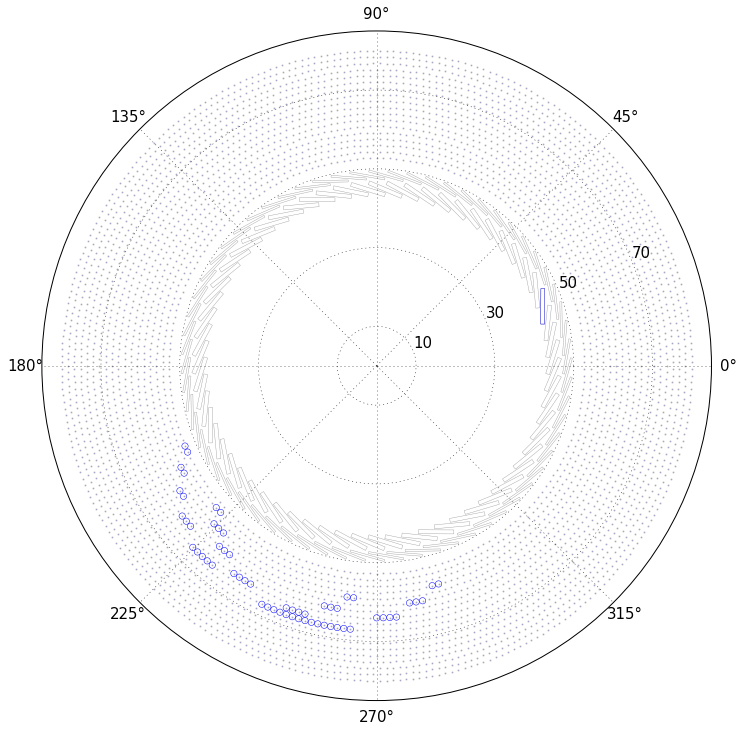

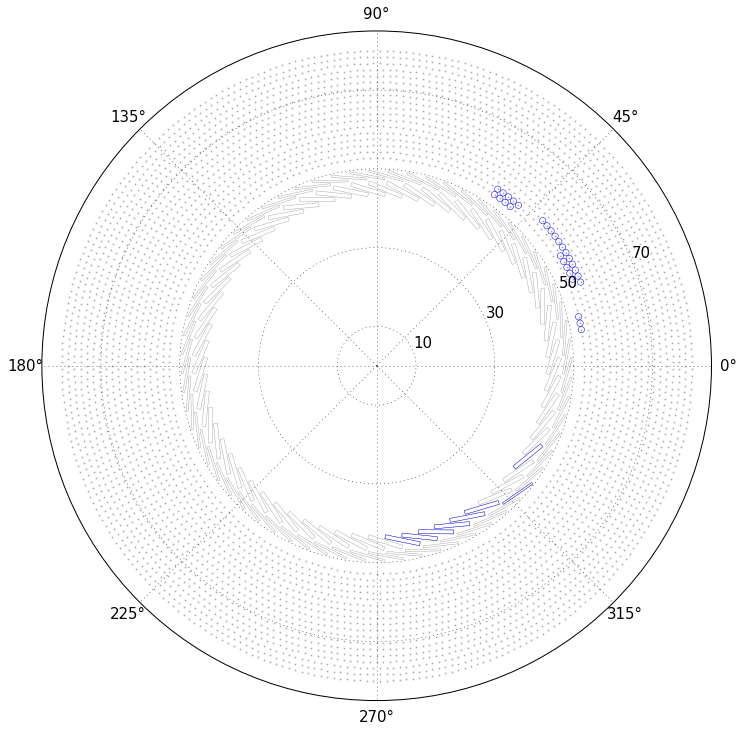

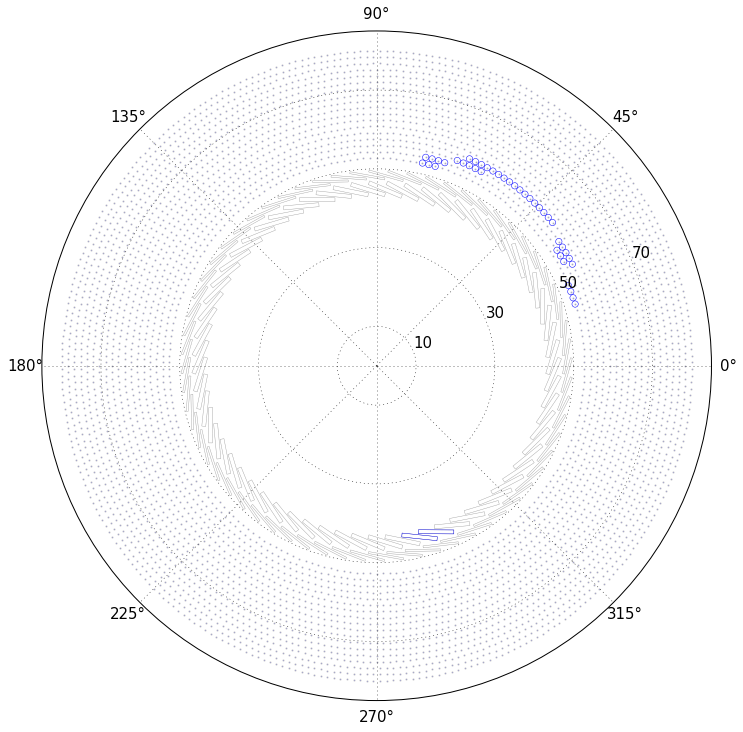

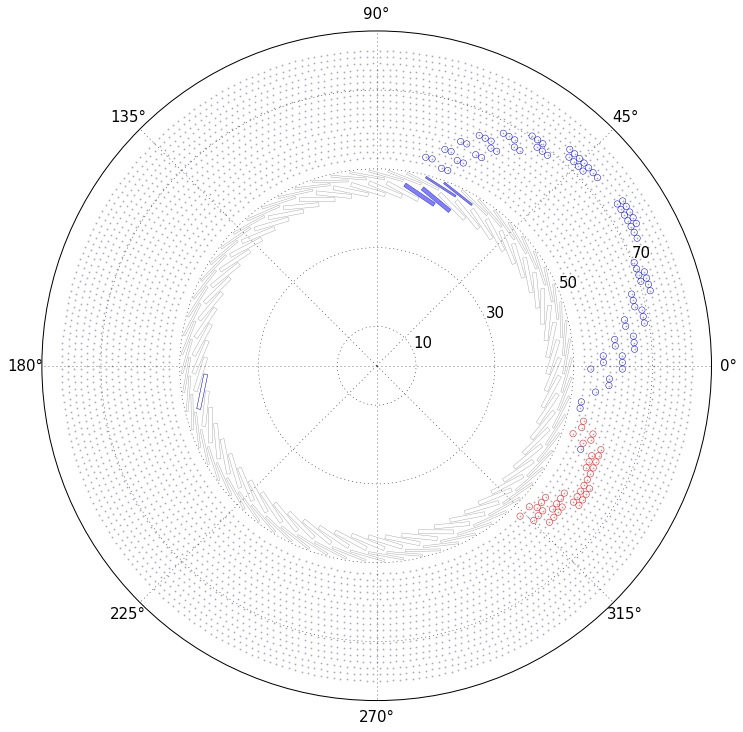

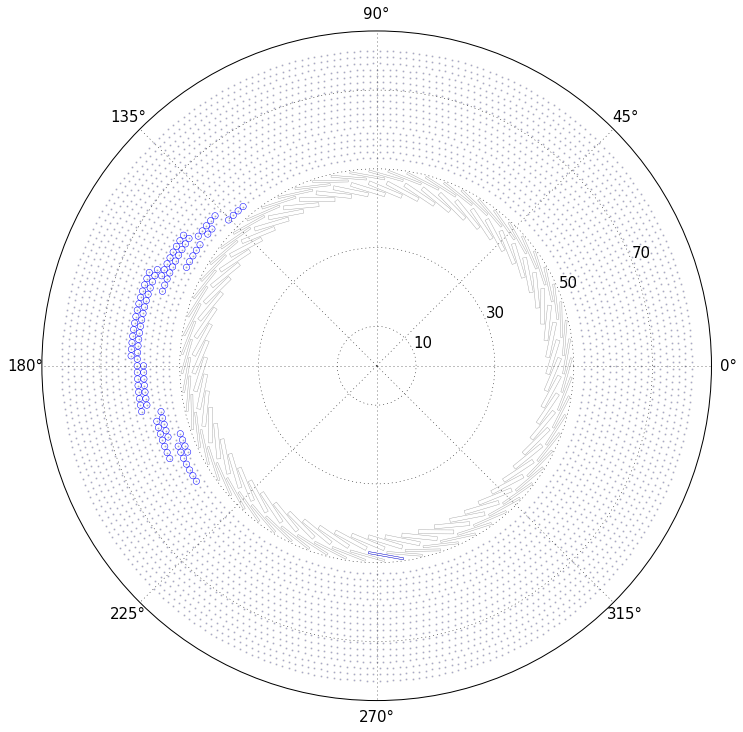

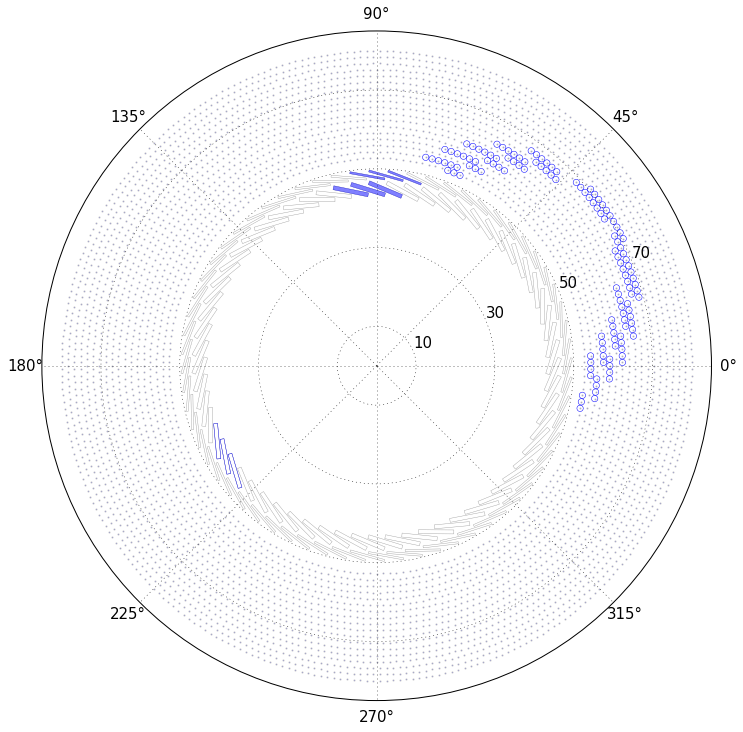

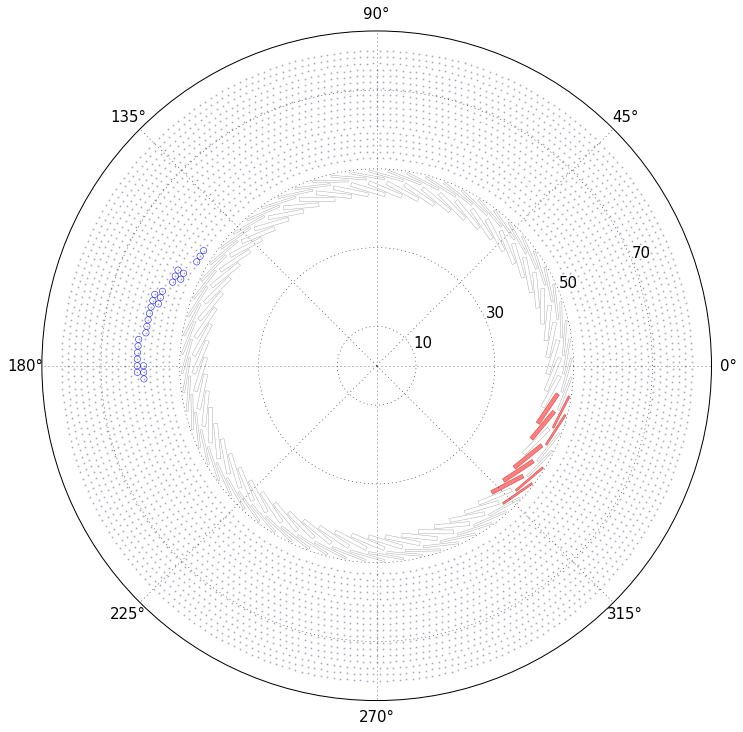

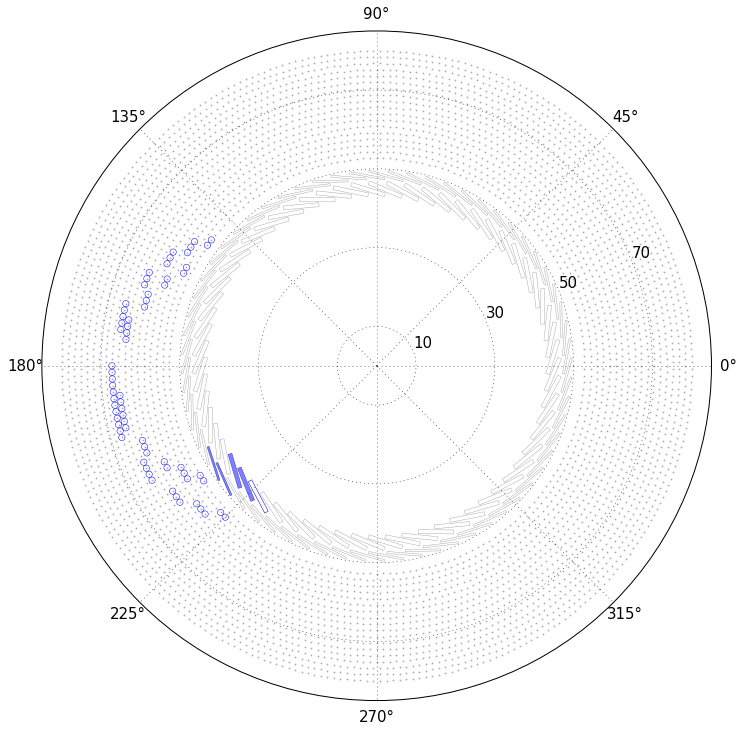

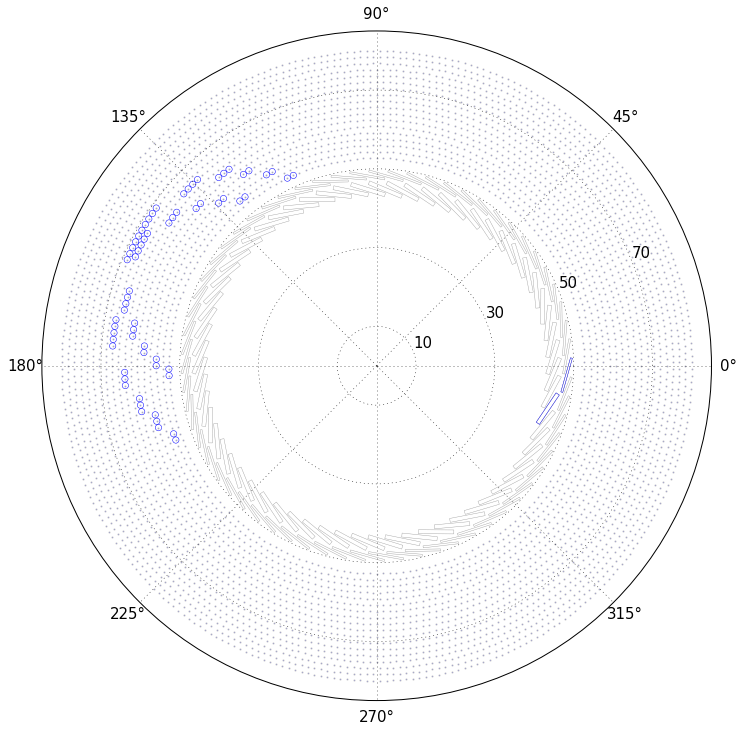

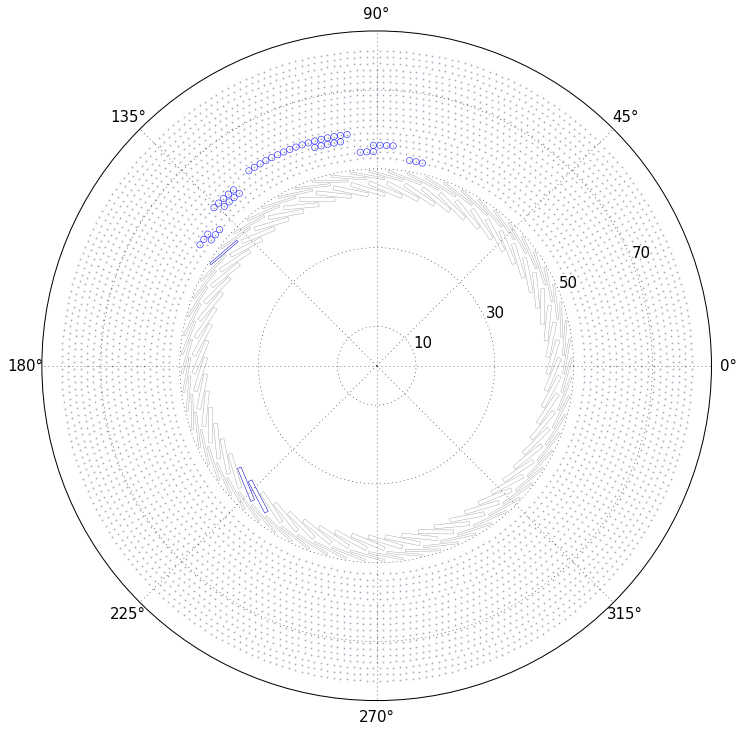

In [68]:
for evt in range(10):
    # Plot the output
    plot_output(np.zeros_like(hits.cdc.get_hit_types(evt)), hits.cdc.geom)
    # Add hit outlines
    plot_add_outlines(hits.cdc.get_hit_types(evt), hits.cdc.geom)
    # Add volume outlines
    plot_add_cth_outlines(hits.cth.geom)
    # Add the CTH vols with hits
    cth_vol_types = hits.cth.get_vol_types(evt)
    plot_add_cth(cth_vol_types, hits.cth.get_trig_vector(evt)[0], hits.cth.geom)
    cth_hits = hits.cth.get_events(evt)
    cdc_hits = hits.cdc.get_signal_hits(evt)
    #plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, transform=gca().transData._b)
    #plt.scatter(cdc_hits[cdc_x_pos_name], cdc_hits[cdc_y_pos_name], s=1, transform=gca().transData._b)
    plt.show()